In [1]:
import utils

In [35]:
from ultralytics import YOLO

# Load a COCO-pretrained YOLO11n-seg model
model = YOLO("yolo11s-seg.pt")

# Train the model for 100 epochs
results = model.train(data="datasets/goat_big_color/data.yaml", epochs=100, imgsz=640, name="yolov11s_big_color", save=True)

In [1]:
from ultralytics import YOLO

model = YOLO("./best.pt")

In [ ]:


path = "datasets/goat_yolo_v11/test/images/199_jpg.rf.b5c8920899ddd54b9ab73eb698b3ec2b.jpg"
path = "datasets/goat_yolo_v11/test/images/1303_jpg.rf.5d2842ed5368d6db2d38ded4e8948237.jpg"
path = "datasets/goat_yolo_v11/test/images/106_jpg.rf.20ebe916320dc0f47302993b68e3662e.jpg"
path = "datasets/goat_yolo_v11/test/images/179_jpg.rf.130da7b6ed3713c19597656741428f5e.jpg"
path = "datasets/goat_yolo_v11/test/images/1294_jpg.rf.22f6fc35b32c014b57856baf0343fd97.jpg"
path = "datasets/erste_messung"


# Predict with the model
results = model(path)  # predict on an image

for result in results:
    utils.plot(result)



In [7]:
results[0].plot()

array([[[ 94, 146, 187],
        [ 94, 146, 187],
        [ 94, 146, 187],
        ...,
        [215, 208, 210],
        [215, 208, 210],
        [215, 208, 210]],

       [[ 94, 146, 187],
        [ 94, 146, 187],
        [ 94, 146, 187],
        ...,
        [215, 208, 210],
        [215, 208, 210],
        [215, 208, 210]],

       [[ 94, 146, 187],
        [ 94, 146, 187],
        [ 94, 146, 187],
        ...,
        [215, 208, 210],
        [215, 208, 210],
        [215, 208, 210]],

       ...,

       [[127, 166, 195],
        [127, 166, 195],
        [127, 166, 195],
        ...,
        [ 62,  73,  82],
        [ 62,  73,  82],
        [ 62,  73,  82]],

       [[127, 166, 195],
        [127, 166, 195],
        [127, 166, 195],
        ...,
        [ 62,  73,  82],
        [ 62,  73,  82],
        [ 62,  73,  82]],

       [[127, 166, 195],
        [127, 166, 195],
        [127, 166, 195],
        ...,
        [ 62,  73,  82],
        [ 62,  73,  82],
        [ 62,  73,  82]]

In [15]:
from ultralytics import YOLO

# Load the YOLO11 model
# model = YOLO("yolo11n.pt")

# Export the model to TF.js format
model.export(format="tfjs")  # creates '/yolo11n_web_model'



Ultralytics 8.3.80 🚀 Python-3.8.10 torch-2.4.1+cu121 CPU (11th Gen Intel Core(TM) i7-11800H 2.30GHz)

PyTorch: starting from 'best.pt' with input shape (1, 3, 640, 640) BCHW and output shape(s) ((1, 37, 8400), (1, 32, 160, 160)) (5.7 MB)

TensorFlow SavedModel: starting export with tensorflow 2.13.1...

ONNX: starting export with onnx 1.17.0 opset 19...
ONNX: slimming with onnxslim 0.1.48...
ONNX: export success ✅ 1.0s, saved as 'best.onnx' (11.1 MB)
TensorFlow SavedModel: starting TFLite export with onnx2tf 1.20.0...
TensorFlow SavedModel: export success ✅ 16.4s, saved as 'best_saved_model' (27.9 MB)

TensorFlow GraphDef: starting export with tensorflow 2.13.1...
TensorFlow GraphDef: export success ✅ 1.2s, saved as 'best.pb' (11.1 MB)

TensorFlow.js: starting export with tensorflowjs 4.22.0...

TensorFlow.js: output node names: Identity:0,Identity_1:0
TensorFlow.js: running 'tensorflowjs_converter --input_format=tf_frozen_model  --output_node_names=Identity:0,Identity_1:0 "best.pb" "b

weight model_65/tf.strided_slice_45/ones_like/tensor with shape (3,) and dtype int64 was auto converted to the type int32
weight model_65/tf.strided_slice_45/StridedSlice/end with shape (3,) and dtype int64 was auto converted to the type int32
weight model_65/tf.strided_slice_45/ones_like with shape (3,) and dtype int64 was auto converted to the type int32
weight model_65/tf.strided_slice_42/StridedSlice/begin with shape (3,) and dtype int64 was auto converted to the type int32
weight model_65/tf.strided_slice_42/StridedSlice/end with shape (3,) and dtype int64 was auto converted to the type int32
weight model_65/tf.strided_slice_42/StridedSlice/strides with shape (3,) and dtype int64 was auto converted to the type int32
weight model_65/tf.strided_slice_44/ones_like/tensor with shape (3,) and dtype int64 was auto converted to the type int32
weight model_65/tf.strided_slice_44/StridedSlice/end with shape (3,) and dtype int64 was auto converted to the type int32
weight model_65/tf.stride

'best_web_model'

In [16]:
# Load the exported TF.js model
tfjs_model = YOLO("./best_web_model")

# Run inference
results = tfjs_model("datasets/goat_yolo_v11/test/images/1294_jpg.rf.22f6fc35b32c014b57856baf0343fd97.jpg")

WARNING ⚠️ Unable to automatically guess model task, assuming 'task=detect'. Explicitly define task for your model, i.e. 'task=detect', 'segment', 'classify','pose' or 'obb'.


NotImplementedError: YOLOv8 TF.js inference is not currently supported.


image 1/1 /home/jonas/projects/jupyterlab/datasets/erste_messung/IMG_1600_Twentyone.JPG: 640x480 1 goat, 132.8ms
Speed: 7.7ms preprocess, 132.8ms inference, 9.1ms postprocess per image at shape (1, 3, 640, 480)
start 106
end 398
front_feed_x 170
back_feed_x 397
body_length: 274
shoulder_height: 208
sacrum_height: 197
body_length cm: 91.07476515249002
shoulder height cm:  69.13704799897054
sacrum height cm: 65.48076180671728


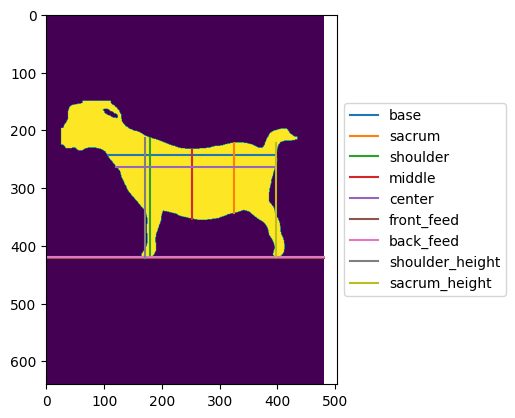

In [ ]:
path = "datasets/erste_messung/IMG_1600_Twentyone.JPG"

# Predict with the model
results = model(path)  # predict on an image

for result in results:
    mask = result.masks.data.cpu()[0]
    body_length, shoulder_height, sacrum_height = utils.body_measurement(mask.numpy())
    distance = 1.64
    body_length = utils.pixels_to_cm(scale_to_width(body_length), distance)
    shoulder_height = utils.pixels_to_cm(scale_to_height(shoulder_height), distance)
    sacrum_height = utils.pixels_to_cm(scale_to_height(sacrum_height), distance)
    print("body_length cm:", body_length)
    print("shoulder height cm: ", shoulder_height)
    print("sacrum height cm:", sacrum_height)

    